In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) 
from sklearn import preprocessing
import datetime as dt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('sample_data.csv')
#df = df.drop(columns=['Unnamed: 0'])
df.head()

fl_date mkt_unique_carrier  mkt_carrier_fl_num origin dest  \
0  2018-01-07                 UA                1171    CLE  LAX   
1  2018-01-07                 AS                 410    SEA  LAX   
2  2018-01-07                 B6                1323    JFK  LAX   
3  2018-01-07                 G4                 341    MFR  LAX   
4  2018-01-07                 DL                  41    JFK  LAX   

   crs_dep_time  crs_arr_time  crs_elapsed_time  distance  arr_delay  precip  \
0          1914          2145             331.0    2052.0      -63.0     0.0   
1          1620          1905             165.0     954.0        2.0     0.0   
2          1525          1904             399.0    2475.0      -34.0     0.0   
3          2003          2155             112.0     630.0       15.0     0.0   
4          1655          2027             392.0    2475.0       38.0     0.0   

   snow  windgust  cloudcover  
0   0.0       0.0        85.0  
1   0.0       0.0        85.0  
2   0.0       0.0        85.0  
3   0.0       0.0        85.0  
4   0.0       0.0        85.0

In [3]:
# cols in test file
df = df[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', \
         'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', \
         'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 'crs_elapsed_time', \
         'flights', 'distance', 'arr_delay']].copy()

In [4]:
# drop columns that are highly correlated with others
df = df.drop(columns=['branded_code_share', 'mkt_carrier', 'op_unique_carrier', 'op_carrier_fl_num', 'flights', 'origin_airport_id', 'origin_city_name', 'dest_airport_id', 'dest_city_name', 'tail_num', 'dup'])

In [4]:
# drop rows with null values
df = df.dropna()

In [5]:
df.shape

(12592, 14)

In [6]:
df.dtypes

fl_date                object
mkt_unique_carrier     object
mkt_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time            int64
crs_arr_time            int64
crs_elapsed_time      float64
distance              float64
arr_delay             float64
precip                float64
snow                  float64
windgust              float64
cloudcover            float64
dtype: object

In [7]:
# look at outliers
flights_over_120h_late = df[df['arr_delay']>120].shape[0]
percent = flights_over_120h_late/df.shape[0]
print(flights_over_120h_late, percent)
 

356 0.028271918678526048


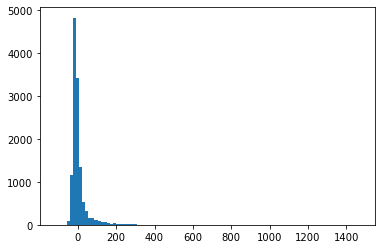

In [8]:
plt.hist(df['arr_delay'], bins=100);

/home/aj/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='arr_delay'>

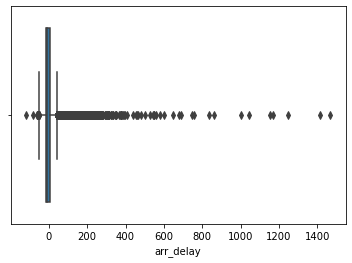

In [9]:
sns.boxplot(df['arr_delay'])

In [10]:
df['arr_delay'].describe()

count    12592.000000
mean         5.186309
std         55.429768
min       -119.000000
25%        -16.000000
50%         -7.000000
75%          7.000000
max       1467.000000
Name: arr_delay, dtype: float64

In [8]:
IQR = (df['arr_delay'].quantile(0.75)-df['arr_delay'].quantile(0.25))

In [9]:
lower_outlier = df['arr_delay'].quantile(0.25) - 1.5*IQR
upper_outlier = df['arr_delay'].quantile(0.75) + 1.5*IQR
print(lower_outlier, upper_outlier)

-50.5 41.5


In [10]:
# get rid of approximately 3% of the top delays (consider them outliers)
df = df[(df['arr_delay'] < upper_outlier) & (df['arr_delay'] > lower_outlier)]

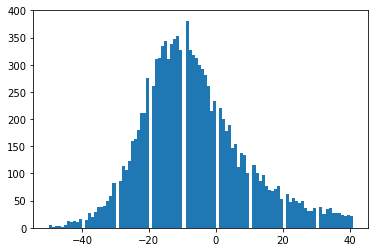

In [11]:
plt.hist(df['arr_delay'], bins=100);

In [12]:
# function to label encode desired columns
def label_encode(df, cols):
    le = preprocessing.LabelEncoder()
    for i in cols:
        df[i] = le.fit_transform(df[i].values)
    return df

In [13]:
df.head()

fl_date mkt_unique_carrier  mkt_carrier_fl_num origin dest  \
1  2018-01-07                 AS                 410    SEA  LAX   
2  2018-01-07                 B6                1323    JFK  LAX   
3  2018-01-07                 G4                 341    MFR  LAX   
4  2018-01-07                 DL                  41    JFK  LAX   
5  2019-11-16                 AA                5726    OKC  DFW   

   crs_dep_time  crs_arr_time  crs_elapsed_time  distance  arr_delay  precip  \
1          1620          1905             165.0     954.0        2.0     0.0   
2          1525          1904             399.0    2475.0      -34.0     0.0   
3          2003          2155             112.0     630.0       15.0     0.0   
4          1655          2027             392.0    2475.0       38.0     0.0   
5           834           947              73.0     175.0       -9.0     0.0   

   snow  windgust  cloudcover  
1   0.0       0.0        85.0  
2   0.0       0.0        85.0  
3   0.0       0.0        85.0  
4   0.0       0.0        85.0  
5   0.0       0.0        54.1

In [14]:
# define columns to encode
cols_to_encode = ['mkt_unique_carrier', 'origin', 'dest']
df_encoded = label_encode(df, cols_to_encode)

In [15]:
df_encoded.head()

fl_date  mkt_unique_carrier  mkt_carrier_fl_num  origin  dest  \
1  2018-01-07                   1                 410     239     5   
2  2018-01-07                   2                1323     137     5   
3  2018-01-07                   5                 341     168     5   
4  2018-01-07                   3                  41     137     5   
5  2019-11-16                   0                5726     192     2   

   crs_dep_time  crs_arr_time  crs_elapsed_time  distance  arr_delay  precip  \
1          1620          1905             165.0     954.0        2.0     0.0   
2          1525          1904             399.0    2475.0      -34.0     0.0   
3          2003          2155             112.0     630.0       15.0     0.0   
4          1655          2027             392.0    2475.0       38.0     0.0   
5           834           947              73.0     175.0       -9.0     0.0   

   snow  windgust  cloudcover  
1   0.0       0.0        85.0  
2   0.0       0.0        85.0  
3   0.0       0.0        85.0  
4   0.0       0.0        85.0  
5   0.0       0.0        54.1

In [16]:
# convert flight date from string to datetime
df_encoded['fl_date'] = pd.to_datetime(df_encoded['fl_date'])
df_encoded.dtypes

fl_date               datetime64[ns]
mkt_unique_carrier             int64
mkt_carrier_fl_num             int64
origin                         int64
dest                           int64
crs_dep_time                   int64
crs_arr_time                   int64
crs_elapsed_time             float64
distance                     float64
arr_delay                    float64
precip                       float64
snow                         float64
windgust                     float64
cloudcover                   float64
dtype: object

In [17]:
# extract additional information from flight date
df_encoded['year'] = df_encoded['fl_date'].dt.year
df_encoded['month'] = df_encoded['fl_date'].dt.month
df_encoded['day'] = df_encoded['fl_date'].dt.day
df_encoded['dayofweek'] = df_encoded['fl_date'].dt.dayofweek

In [19]:
df_encoded.head()

fl_date  mkt_unique_carrier  mkt_carrier_fl_num  origin  dest  \
1 2018-01-07                   1                 410     239     5   
2 2018-01-07                   2                1323     137     5   
3 2018-01-07                   5                 341     168     5   
4 2018-01-07                   3                  41     137     5   
5 2019-11-16                   0                5726     192     2   

   crs_dep_time  crs_arr_time  crs_elapsed_time  distance  arr_delay  precip  \
1          1620          1905             165.0     954.0        2.0     0.0   
2          1525          1904             399.0    2475.0      -34.0     0.0   
3          2003          2155             112.0     630.0       15.0     0.0   
4          1655          2027             392.0    2475.0       38.0     0.0   
5           834           947              73.0     175.0       -9.0     0.0   

   snow  windgust  cloudcover  year  month  day  dayofweek  
1   0.0       0.0        85.0  2018      1    7          6  
2   0.0       0.0        85.0  2018      1    7          6  
3   0.0       0.0        85.0  2018      1    7          6  
4   0.0       0.0        85.0  2018      1    7          6  
5   0.0       0.0        54.1  2019     11   16          5

In [20]:
df_encoded = df_encoded.drop(columns='fl_date')

In [21]:
# copy desired data into a new data frame
data = df_encoded[['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', 
                  'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'arr_delay', 'precip', 'snow', 'windgust', 'cloudcover']].copy()

In [22]:
data

year  month  day  dayofweek  mkt_unique_carrier  mkt_carrier_fl_num  \
1      2018      1    7          6                   1                 410   
2      2018      1    7          6                   2                1323   
3      2018      1    7          6                   5                 341   
4      2018      1    7          6                   3                  41   
5      2019     11   16          5                   0                5726   
...     ...    ...  ...        ...                 ...                 ...   
12587  2018      3   21          2                   8                4533   
12588  2018      3   31          5                   3                1195   
12589  2019      9   23          0                   0                3842   
12590  2018      8   28          1                   3                5137   
12591  2018      1   14          6                   8                5808   

       origin  dest  crs_dep_time  crs_arr_time  crs_elapsed_time  distance  \
1         239     5          1620          1905             165.0     954.0   
2         137     5          1525          1904             399.0    2475.0   
3         168     5          2003          2155             112.0     630.0   
4         137     5          1655          2027             392.0    2475.0   
5         192     2           834           947              73.0     175.0   
...       ...   ...           ...           ...               ...       ...   
12587     220     6           745           910             145.0     646.0   
12588     145     8          1515          1805             170.0     954.0   
12589      90     6          1154          1348             114.0     557.0   
12590     127     4          1610          1755             105.0     228.0   
12591     195     1           615           914             119.0     599.0   

       arr_delay  precip  snow  windgust  cloudcover  
1            2.0    0.00   0.0       0.0        85.0  
2          -34.0    0.00   0.0       0.0        85.0  
3           15.0    0.00   0.0       0.0        85.0  
4           38.0    0.00   0.0       0.0        85.0  
5           -9.0    0.00   0.0       0.0        54.1  
...          ...     ...   ...       ...         ...  
12587       -9.0    0.00   0.0      38.9        67.8  
12588      -22.0    0.00   0.0       0.0        80.4  
12589        7.0    0.56   0.0      42.5        31.1  
12590      -43.0    0.00   0.0      38.9        52.2  
12591       -9.0    0.00   0.0      25.9        31.9  

[11412 rows x 17 columns]

In [23]:
# look at correlation among remaining variables
df_corr = data.corr()

<AxesSubplot:>

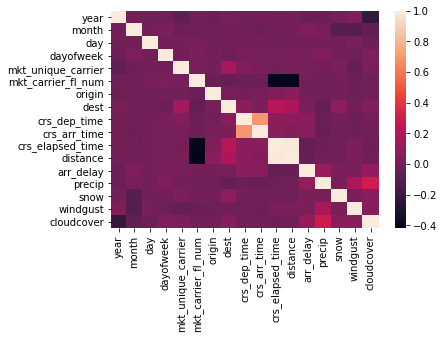

In [24]:
sns.heatmap(df_corr)

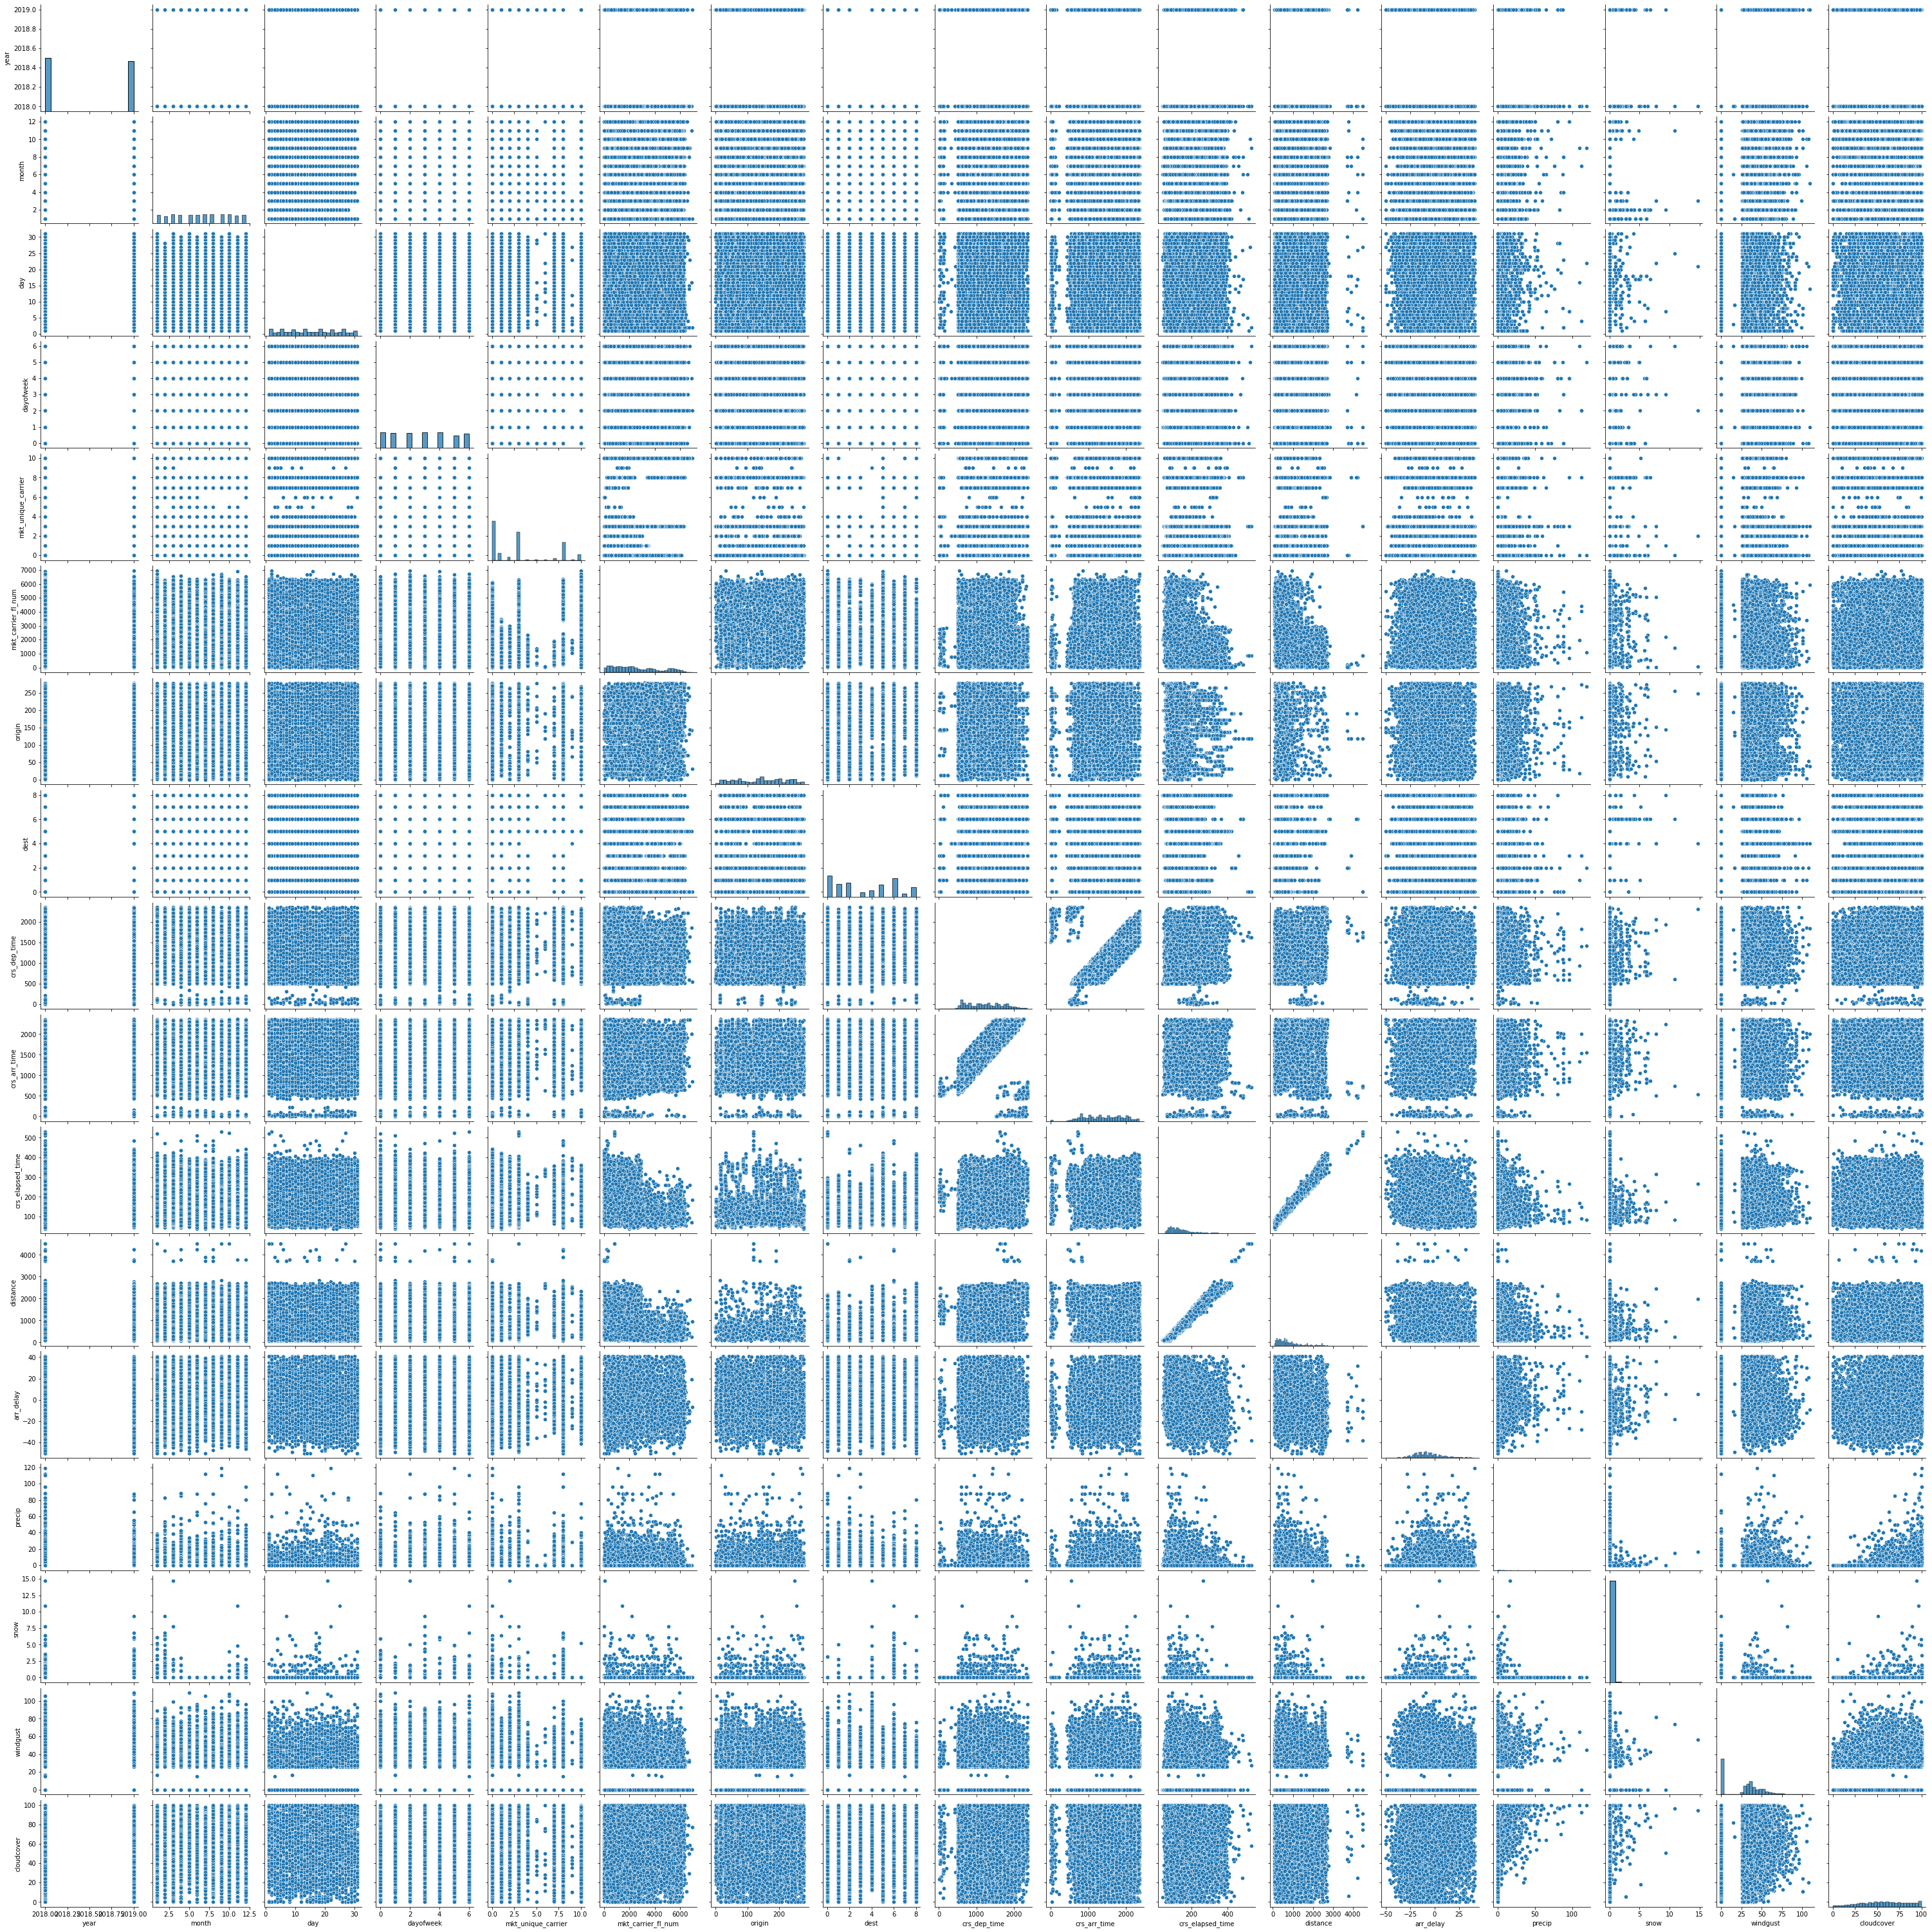

In [31]:
# identify any patterns among the variables
sns.pairplot(data)
plt.show()

In [25]:
scaler = preprocessing.StandardScaler()

In [26]:
X = data.drop(columns='arr_delay').values

In [27]:
y = data['arr_delay'].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [29]:
# Standardize the data using only statistics from the training set
# (always assume no knowledge of the test set for most unbiased performance estimate)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Run different models on the dataset

### Linear Regression

In [30]:
reg = LinearRegression()
k_folds = 5

# Cross-validation
cv_r2 = cross_val_score(reg, X_train, y_train, cv=k_folds, scoring='r2')

# Train model on the entire training set
reg.fit(X_train, y_train)

# Test the model
y_pred_linreg = reg.predict(X_test)

# Calculate metrics
r2_linreg = r2_score(y_test, y_pred_linreg)
rmse_linreg = mean_squared_error(y_test, y_pred_linreg, squared=False)

# Compare traing to test accuracy
linreg_training_accuracy = reg.score(X_train, y_train)
linreg_test_accuracy = reg.score(X_test, y_test)

# Print results
print('Linear Regression')
print('==================')
print(f'Cross-validated R^2\nMean: {cv_r2.mean():.4f}\nStd.: {cv_r2.std():.4f}')
print(f'R^2: {r2_linreg:.4f}')
print(f'RMSE: {rmse_linreg:.4f}')
print(f'Training accuracy: {linreg_training_accuracy:.4f}')
print(f'Test accuracy: {linreg_test_accuracy:.4f}')

Linear Regression
Cross-validated R^2
Mean: 0.0359
Std.: 0.0147
R^2: 0.0285
RMSE: 15.3316
Training accuracy: 0.0404
Test accuracy: 0.0285


### Polynomial Regression

#### Degree = 2

In [31]:
# Create polynomial feature set and train model
Xpoly_train = PolynomialFeatures(degree=2).fit_transform(X_train)
Xpoly_test = PolynomialFeatures(degree=2).fit_transform(X_test)

# Train and test the model
reg.fit(Xpoly_train, y_train)
ypoly_train_pred = reg.predict(Xpoly_train)
ypoly_test_pred = reg.predict(Xpoly_test)

# Calculate metrics
r2_polyreg = r2_score(y_test, ypoly_test_pred)
rmse_polyreg = mean_squared_error(y_test, ypoly_test_pred, squared=False)

# Check performance on train and test set
r2poly_train = r2_score(y_train, ypoly_train_pred)
r2poly_test = r2_score(y_test, ypoly_test_pred)

# Print results
print('Linear Regression with Polynomial Degree = 2')
print('============================================')
print(f'Number of polynomial features: {Xpoly_train.shape[1]}')
print(f'R^2: {r2_polyreg:.4f}')
print(f'RMSE: {rmse_polyreg:.4f}')
print(f'Training accuracy: {r2poly_train:.4f}\nTest accuracy: {r2poly_test:.4f}')

Linear Regression with Polynomial Degree = 2
Number of polynomial features: 153
R^2: 0.0366
RMSE: 15.2672
Training accuracy: 0.0811
Test accuracy: 0.0366


#### Degree = 3

In [32]:
# Create polynomial feature set and train model
Xpoly3_train = PolynomialFeatures(degree=3).fit_transform(X_train)
Xpoly3_test = PolynomialFeatures(degree=3).fit_transform(X_test)

# Train and test the model
reg.fit(Xpoly3_train, y_train)
ypoly3_train_pred = reg.predict(Xpoly3_train)
ypoly3_test_pred = reg.predict(Xpoly3_test)

# Calculate metrics
r2_polyreg3 = r2_score(y_test, ypoly3_test_pred)
rmse_polyreg3 = mean_squared_error(y_test, ypoly3_test_pred, squared=False)

# Check performance on train and test set
r2poly3_train = r2_score(y_train, ypoly3_train_pred)
r2poly3_test = r2_score(y_test, ypoly3_test_pred)

# Print results
print('Linear Regression with Polynomial Degree = 3')
print('============================================')
print(f'Number of polynomial features: {Xpoly3_train.shape[1]}')
print(f'R^2: {r2_polyreg3:.4f}')
print(f'RMSE: {rmse_polyreg3:.4f}')
print(f'Training accuracy: {r2poly3_train:.4f}\nTest accuracy: {r2poly3_test:.4f}')

Linear Regression with Polynomial Degree = 3
Number of polynomial features: 969
R^2: -4.9262
RMSE: 37.8666
Training accuracy: 0.1995
Test accuracy: -4.9262


### Ridge Regression

In [33]:
# define hyperparameters
param_grid = {'alpha': [0.1, 1, 5, 10]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_r2_rr = grid_result.best_score_  
best_alpha_rr = grid_result.best_params_['alpha']
best_rr_model = grid_result.best_estimator_ 

# Predict results
y_pred_rr = best_rr_model.predict(X_test)

# Calculate metrics
r2_test_rr = r2_score(y_test, y_pred_rr)
rmse_rr = mean_squared_error(y_test, y_pred_rr, squared=False)

# Check training and test accuracy
rr_training_accuracy = best_rr_model.score(X_train, y_train)
rr_test_accuracy = best_rr_model.score(X_test, y_test)

# Print results
print('Ridge Regression')
print('================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_rr:.4f}\nAlpha:\t{best_alpha_rr}')
print(f'R^2: {r2_test_rr:.4f}')
print(f'RMSE:  {rmse_rr:.4f}')
print(f'Training accuracy: {rr_training_accuracy:.4f},    Test accuracy: {rr_test_accuracy:.4f}')

Ridge Regression
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0359
Alpha:	1
R^2: 0.0285
RMSE:  15.3316
Training accuracy: 0.0404,    Test accuracy: 0.0285


### Ridge Regresssion on Polynomial (Degree = 3) with grid search

In [34]:
# define hyperparameters
param_grid = {'alpha': [50000, 60000, 80000, 100000]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(Xpoly3_train, y_train)

# Check best hyperparameters and train the best model
best_r2_poly = grid_result.best_score_   
best_alpha_poly = grid_result.best_params_['alpha']
best_rr_poly = grid_result.best_estimator_

# Predict results
y_pred_poly = best_rr_poly.predict(Xpoly3_test)

# Calculate metrics
r2_test_poly = r2_score(y_test, y_pred_poly)
rmse_rr_poly = mean_squared_error(y_test, y_pred_poly, squared=False)

# Check training and test accuracy
rr_poly_training_accuracy = best_rr_poly.score(Xpoly3_train, y_train)
rr_poly_test_accuracy = best_rr_poly.score(Xpoly3_test, y_test)

# Print results
print('Ridge Regresssion on Polynomial (Degree = 3) with grid search')
print('=============================================================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_poly:.4f}\nAlpha:\t{best_alpha_poly}')
print(f'R^2 :{r2_test_poly:.4f}')
print(f'RMSE:  {rmse_rr_poly:.4f}')
print(f'Training accuracy: {rr_poly_training_accuracy:.4f},    Test accuracy: {rr_poly_test_accuracy:.4f}')

Ridge Regresssion on Polynomial (Degree = 3) with grid search
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0135
Alpha:	100000
R^2 :0.0222
RMSE:  15.3812
Training accuracy: 0.0532,    Test accuracy: 0.0222


### Random Forest Regressor

In [35]:
# define hyperparamters
params = {'n_estimators': [500, 1000, 5000], 'max_depth': [1, 3, 5, 7, 12]}

#Create an instance of the model
rf=RandomForestRegressor()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rf, param_grid=params, cv=k_folds, scoring='r2', n_jobs=-1) 
grid_result = grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_n_estimators = grid_result.best_params_['n_estimators']
best_max_depth = grid_result.best_params_['max_depth']
best_model_rf = grid_result.best_estimator_

#rf_cv_score = cross_val_score(best_model_rf, X_train, y_train, cv=k_folds)

# Predict results
y_pred_rf = best_model_rf.predict(X_test)

# Calculate metrics
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

# Check training and test accuracy
rf_training_accuracy = best_model_rf.score(X_train, y_train)
rf_test_accuracy = best_model_rf.score(X_test, y_test)

# Print results
print('Random Forest Regressor')
print('=======================')
print(f'Best number of Trees: {best_n_estimators}\nBest max depth:\t{best_max_depth}')
print(f'R^2 :{r2_rf:.4f}')
print(f'RMSE:  {rmse_rf:.4f}')
print(f'Training accuracy: {rf_training_accuracy:.4f},    Test accuracy: {rf_test_accuracy:.4f}')

KeyboardInterrupt: 

In [ ]:
# Feature analysis for importance
cols = ['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier',
       'mkt_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'distance']

feature_imp = pd.Series(best_model_rf.feature_importances_,index=cols).sort_values(ascending=False)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10,5))
# Create a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels 
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

### XGBRegressor

In [36]:
# define hyperparamters
params = {'objective': ['reg:linear'], 'learning_rate': [0.01, 0.05, 0.09], 'max_depth': [1, 3, 5, 7, 12], \
         'colsample_bytree': [0.7], 'alpha': [0.01, 0.1, 1], 'n_estimators': [150, 250, 500]}

#Create an instance of the model
xgb = xgb.XGBRegressor()
k_folds = 5

# perform cross validation and grid search
xgb_grid = GridSearchCV(estimator=xgb, param_grid=params, cv=k_folds, scoring='r2', n_jobs=-1) 
xgb_grid_result = xgb_grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_n_estimators = xgb_grid_result.best_params_['n_estimators']
best_max_depth = xgb_grid_result.best_params_['max_depth']
best_learning_rate = xgb_grid_result.best_params_['learning_rate']
best_alpha = xgb_grid_result.best_params_['alpha']
best_model_xgb = xgb_grid_result.best_estimator_

# Predict results
y_pred_xgb = best_model_xgb.predict(X_test)

# Calculate metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

# Check training and test accuracy
xgb_training_accuracy = best_model_xgb.score(X_train, y_train)
xgb_test_accuracy = best_model_xgb.score(X_test, y_test)

# Print results
print('XGBRegressor')
print('============')
print(f'Best number of Trees: {best_n_estimators}\nBest max depth:\t{best_max_depth}')
print(f'Best learning rate: {best_learning_rate}\nBest alpha:\t{best_alpha}')
print(f'R^2 :{r2_xgb:.4f}')
print(f'RMSE:  {rmse_xgb:.4f}')
print(f'Training accuracy: {xgb_training_accuracy:.4f},    Test accuracy: {xgb_test_accuracy:.4f}')

/home/aj/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

### Round 1 results:

Data variables = ['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', \
                  'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'arr_delay']


**Linear Regression**
Cross-validated R^2
Mean: 0.0115
Std.: 0.0043
R^2: 0.0077
RMSE: 54.8165
Training accuracy: 0.0164
Test accuracy: 0.0077

**Linear Regression with Polynomial Degree = 2**
Number of polynomial features: 91
R^2: 0.0072
RMSE: 54.8285
Training accuracy: 0.0298
Test accuracy: 0.0072

**Linear Regression with Polynomial Degree = 3**
Number of polynomial features: 455
R^2: -0.0340
RMSE: 55.9557
Training accuracy: 0.0864
Test accuracy: -0.0340

**Ridge Regression**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0116
Alpha:	10
R^2: 0.0077
RMSE:  54.8156
Training accuracy: 0.0164,    Test accuracy: 0.0077

**Ridge Regresssion on Polynomial (Degree = 3) with grid search**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0035
Alpha:	80000
R^2 :0.0138
RMSE:  14.9820
Training accuracy: 0.0198,    Test accuracy: 0.0138

**Random Forest Regressor**
Best number of Trees: 5000
Best max depth:	1
R^2 :0.0081
RMSE:  54.8048
Training accuracy: 0.0154,    Test accuracy: 0.0081

**XGBRegressor**
Best number of Trees: 250
Best max depth:	1
Best learning rate: 0.05
Best alpha:	0.1
R^2 :0.0157
RMSE:  48.9381
Training accuracy: 0.0270,    Test accuracy: 0.0157


### Round 2 results:
Got rid of outliers in arr_delay (anything below Q1 - 1.5*IQR or anything above Q3 + 1.5*IQR)

Data variables = ['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', \
                  'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'arr_delay']

**Not finely tuning the hyperparameters at this stage because error is too high and don't want to waste time running models that don't yet work well**

**Linear Regression**
Cross-validated R^2
Mean: 0.0097
Std.: 0.0088
R^2: 0.0249
RMSE: 14.8973
Training accuracy: 0.0164
Test accuracy: 0.0249

**Linear Regression with Polynomial Degree = 2**
Number of polynomial features: 91
R^2: 0.0203
RMSE: 14.9324
Training accuracy: 0.0408
Test accuracy: 0.0203

**Linear Regression with Polynomial Degree = 3**
Number of polynomial features: 455
R^2: -0.0450
RMSE: 15.4217
Training accuracy: 0.1039
Test accuracy: -0.0450

**Ridge Regression**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0097
Alpha:	1
R^2: 0.0249
RMSE:  14.8976
Training accuracy: 0.0164,    Test accuracy: 0.0249

**Ridge Regresssion on Polynomial (Degree = 3) with grid search**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0146
Alpha:	50000
R^2 :0.0160
RMSE:  24.5943
Training accuracy: 0.0330,    Test accuracy: 0.0160

**Random Forest Regressor**   
Best number of Trees: 500
Best max depth:	7
R^2 :0.0229
RMSE:  14.9129
Training accuracy: 0.1321,    Test accuracy: 0.0229

**XGBRegressor**
Best number of Trees: 500
Best max depth:	3
Best learning rate: 0.01
Best alpha:	0.1
R^2 :0.0235
RMSE:  14.9079
Training accuracy: 0.0715,    Test accuracy: 0.0235